In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
csv_names = [f for f in os.listdir("results") if os.path.isfile(os.path.join("results", f)) and f.endswith(".csv")]
files = [os.path.join("results", f) for f in csv_names]

csv_names

['actix-web.csv',
 'regex.csv',
 'async_std.csv',
 'syn.csv',
 'tokio.csv',
 'bevy_ecs.csv',
 'serde_json.csv',
 'clap.csv']

In [3]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df["published_at"] = pd.to_datetime(df["published_at"], unit="s")
df.head()

,name,version,published_at,edition,reported_msrv,version_signature,unsafe_exprs,total_exprs,unsafe_fraction,clippy_warnings,clippy_warnings_per_expr,async_fns,total_fns,async_fraction
0,actix-web,4.4.1,2023-12-24 16:46:19,2,68.0,23.012432,1158,22125,0.052339,0,0.000000,16,1364,0.011730
1,actix-web,4.2.1,2022-09-12 09:44:11,1,NaN,23.337967,784,18083,0.043356,11,0.000608,10,1264,0.007911
2,actix-web,3.3.3,2021-12-18 22:58:03,1,NaN,23.429869,798,11822,0.067501,36,0.003045,15,743,0.020188
3,regex,1.10.2,2023-10-16 14:46:09,2,65.0,17.438885,2,2911,0.000687,0,0.000000,0,371,0.000000
4,regex,1.9.2,2023-08-05 18:32:28,2,60.0,17.438883,2,2911,0.000687,0,0.000000,0,371,0.000000


In [4]:
metrics = ["edition", "reported_msrv", "version_signature", "unsafe_fraction", "clippy_warnings_per_expr", "async_fraction"]

def show_metric(metric, label, no_all_zero=False):
    plt.figure()

    for name in df["name"].unique():
        subset = df[df["name"] == name]
        plt.plot(subset["published_at"], subset[metric], label=name)

        if no_all_zero and len(subset[subset[metric] != 0]) == 0:
            continue

        for i, txt in enumerate(subset['version']):
            plt.annotate(txt,
                         (subset['published_at'].iloc[i], subset[metric].iloc[i]),
                         size=8, color="#888888aa")

    plt.title(f"{label} over time")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.show()

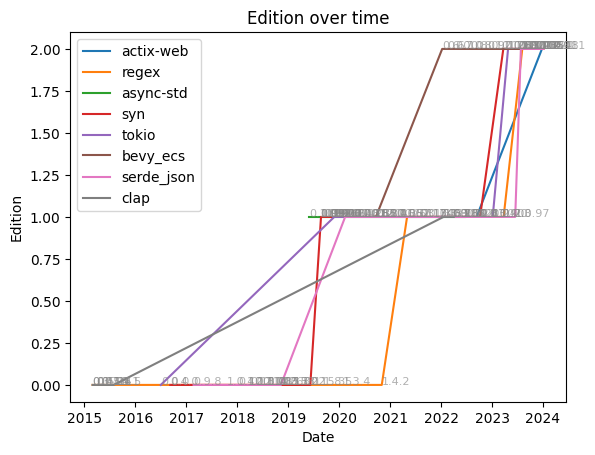

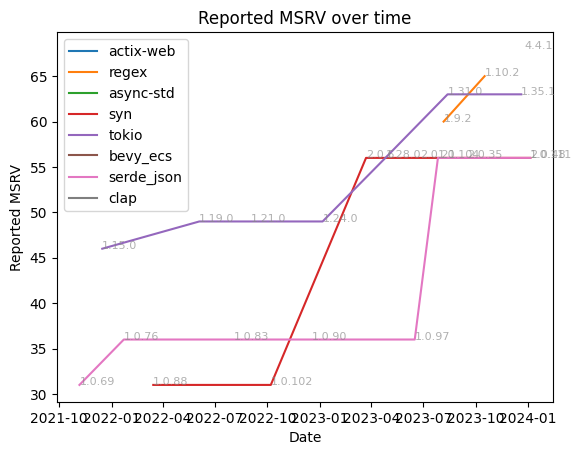

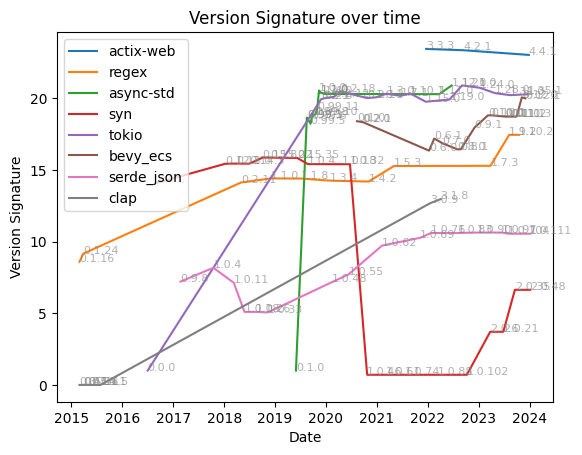

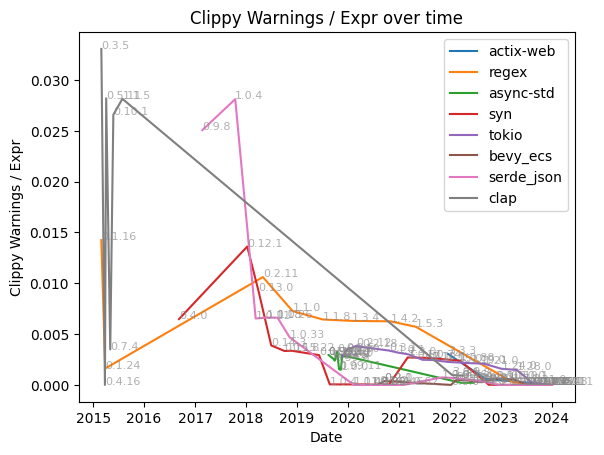

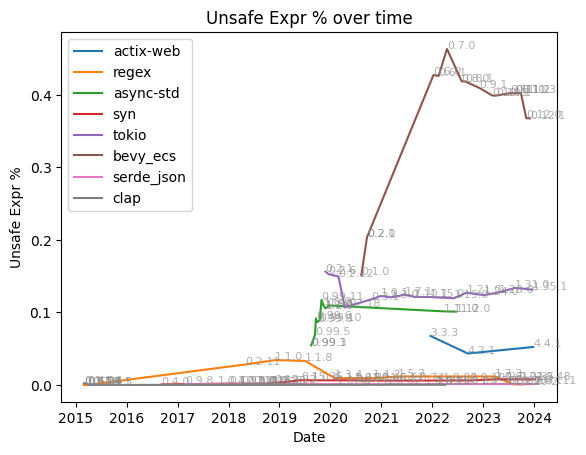

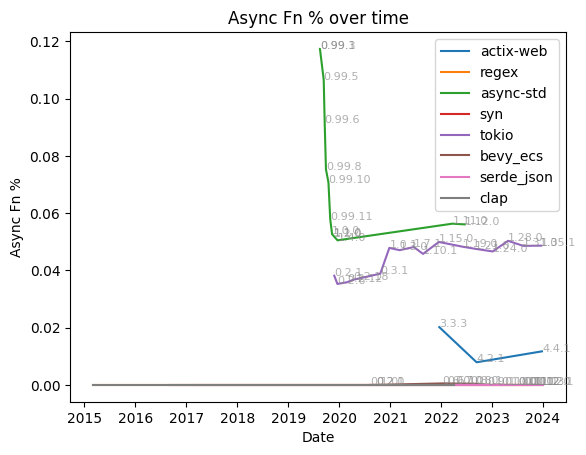

In [5]:
show_metric("edition", "Edition")
show_metric("reported_msrv", "Reported MSRV")
show_metric("version_signature", "Version Signature")
show_metric("clippy_warnings_per_expr", "Clippy Warnings / Expr")
show_metric("unsafe_fraction", "Unsafe Expr %")
show_metric("async_fraction", "Async Fn %", no_all_zero=True)